In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy
from scipy import signal
from scipy.io import wavfile
from scipy import integrate
# import local developed functions
import scnr
from pyroomacoustics.denoise import apply_iterative_wiener
%matplotlib notebook

In [7]:
def stft(x, fftsize=128, hop=80):
    w = scipy.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]  
#    w = scipy.hanning(fftsize)
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)+1-fftsize, hop)])

def istft(X, fftsize=128 ,hop=80):
    w = scipy.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]
    x = scipy.zeros((X.shape[0]-1)*hop+fftsize)
    wsum = scipy.zeros((X.shape[0]-1)*hop+fftsize) 
    for n,i in enumerate(range(0, len(x)-fftsize+1, hop)):
#        print((np.fft.irfft(X[n])))
        x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    pos = wsum != 0
    x[pos] /= wsum[pos]
    return x

In [10]:
# input a noised utterance of .wav
fs, noised_in = wavfile.read('./pcm_wav_left_Stream-2019-12-11-22_28.wav')
freq_in = stft(noised_in[:320000])
scnr_specsub = scnr.SpectralSub(nfft=128, db_reduc=10, lookback=3, beta=2, alpha=2)
for n in range(np.shape(freq_in)[0]):
    gain_filt = scnr_specsub.compute_gain_filter(freq_in[n, :])
    freq_in[n, :] = freq_in[n, :] * gain_filt[:]

filtered_out = istft(freq_in)

# add high-pass filter
DF_numer = np.array([0.9565432255568771, -1.9130864511137542, 0.9565432255568771], dtype=float)
DF_denom = np.array([1, -1.9111970674260734, 0.9149758348014341], dtype=float)
filtered_out = signal.lfilter(DF_numer, DF_denom, filtered_out)
wavfile.write('./scnr_out.wav', fs, filtered_out)
ipd.Audio(data=filtered_out, rate=fs)

<IPython.core.display.Javascript object>


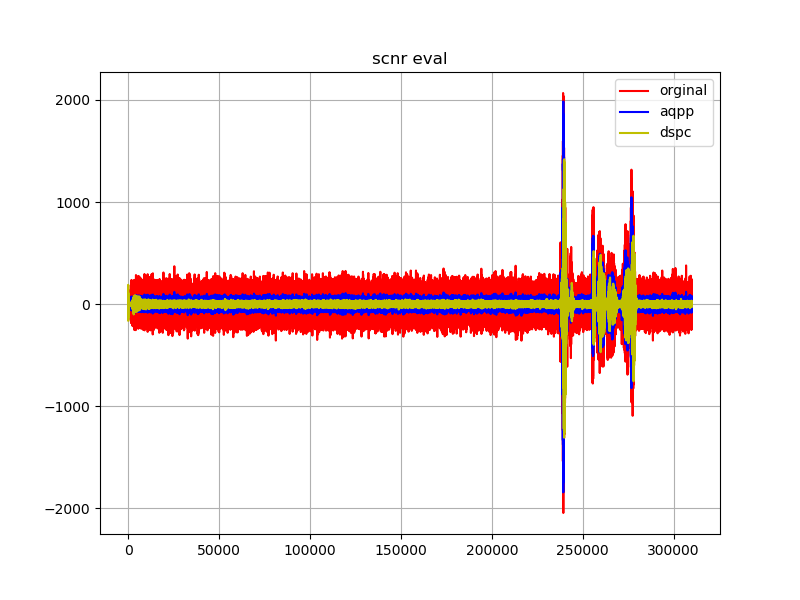

In [18]:
fs, dspc_out = wavfile.read('./dspc_wavStream-2019-12-11-22_28.wav')
fs, audacity_out = wavfile.read('./audacity_scnrout.wav')
fig = plt.figure(figsize=(8,6))
plt.title("scnr eval")
plt.plot(noised_in[:310000], 'r')
plt.plot(audacity_out[:310000], 'b')
plt.plot(dspc_out[:310000], 'y')
plt.legend(('orginal', 'aqpp', 'dspc'), loc='best')
plt.grid(True)
plt.show()

In [16]:
denoised_signal = apply_iterative_wiener(noised_in, frame_len=128,lpc_order=2, iterations=2,alpha=0.8, thresh=0.8)
# normalize
denoised_signal = denoised_signal - np.mean(denoised_signal)
denoised_signal = denoised_signal / np.max(np.abs(denoised_signal))

fig = plt.figure(figsize=(8,6))
plt.title("scnr eval")
plt.plot(noised_in[:340000], 'r')
plt.plot(denoised_signal[:340000], 'b')
plt.legend(('orginal', 'denoised'), loc='best')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
wavfile.write('./scnr_out_wiener.wav', fs, denoised_signal)
ipd.Audio(data=denoised_signal, rate=fs)